# The Caring Home / Helpful Home Continued

A model that can look for non normal situations in a elderly person home, from smart home IoT sensors.

## Enter The Frontier!

And now - we put Frontier Models to the test.

### 2 important points:

It's important to appreciate that we aren't Training the frontier models. We're only providing them with the Test dataset to see how they perform. They don't gain the benefit of the 400,000 training examples that we provided to the Traditional ML models.

HAVING SAID THAT...

It's entirely possible that in their monstrously large training data, they've already been exposed to all the products in the training AND the test set. So there could be test "contamination" here which gives them an unfair advantage. We should keep that in mind.

In [2]:
# imports

import os
import sys
import re
import math
import json
import random
from dotenv import load_dotenv
from huggingface_hub import login
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter
from openai import OpenAI
from anthropic import Anthropic

In [3]:
# Get the root project directory (one level up from the docs folder)
root_project_path = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Add the src folder to the path
sys.path.insert(0, os.path.join(root_project_path, "src"))

In [4]:
from items import Item


In [5]:
# moved our Tester into a separate package
# call it with Tester.test(function_name, test_dataset)

from testing import Tester

In [6]:
# We will use Ollama locally for some models so we will need requests
import requests

In [7]:
# environment

load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['OPENROUTER_API_KEY'] = os.getenv('OPENROUTER_API_KEY', 'your-key-if-not-using-env')
os.environ['HYPERBOLIC_API_KEY'] = os.getenv('HYPERBOLIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [8]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [9]:
openai = OpenAI()
claude = Anthropic()

In [18]:
%matplotlib inline

In [10]:
# Let's avoid curating all our data again! Load in the pickle files:

with open('../data/train.pkl', 'rb') as file:
    train = pickle.load(file)

with open('../data/test.pkl', 'rb') as file:
    test = pickle.load(file)

## First, the humble but mighty GPT-4o-mini

It's called mini, but it packs a punch.

In [11]:
# First let's work on a good prompt for a Frontier model
# Notice that I'm removing the " to the nearest dollar"
# When we train our own models, we'll need to make the problem as easy as possible, 
# but a Frontier model needs no such simplification.

def messages_for(item):
    system_message = "You look for normal and anomalous situations in smart home sensor data in an elderly persons home. Reply only with the word normal or anomalous, no explanation. You should consider the timing of the events and whether this is typical for an elderly person. You must also consider the time between the events and the sequencing of the events to check if they are normal for an elderly person"
    user_prompt = item.test_prompt().replace("\n\nResult is ","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Result is "}
    ]

In [12]:
# Try this out
#test[0].details
messages_for(test[0])

[{'role': 'system',
  'content': 'You look for normal and anomalous situations in smart home sensor data in an elderly persons home. Reply only with the word normal or anomalous, no explanation. You should consider the timing of the events and whether this is typical for an elderly person. You must also consider the time between the events and the sequencing of the events to check if they are normal for an elderly person'},
 {'role': 'user',
  'content': 'How would you classify this sensor data - normal or anomalous?\n\n[{"timestamp": 1709341500, "room": "entrance", "nodeId": 7, "endpointId": 1, "attribute": {"Event": {"Event": "door_opened"}}, "datetime": "Sat Mar 02 2024 01:05:00"}, {"timestamp": 1709341530, "room": "entrance", "nodeId": 7, "endpointId": 1, "attribute": {"Event": {"Event": "door_closed"}}, "datetime": "Sat Mar 02 2024 01:05:30"}, {"timestamp": 1709346600, "room": "entrance", "nodeId": 7, "endpointId": 1, "attribute": {"Event": {"Event": "door_opened"}}, "datetime": "

In [13]:
# A utility function to extract the result from a string

def get_result(text):
    # Match "normal" or "anomalous" anywhere in the text
    match = re.search(r"\b(normal|anomalous)\b", text, re.IGNORECASE)
    return match.group(1).lower() if match else None

In [14]:
get_result("The result is anomalous because blah blah")

'anomalous'

In [15]:
get_result("anomalous")

'anomalous'

In [16]:
# The function for gpt-4o-mini

def gpt_4o_mini(item):
    response = openai.chat.completions.create(
        model="gpt-4o-mini", 
        messages=messages_for(item),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_result(reply)

In [17]:
test[0].result

'anomalous'

1: Guess: normal Truth: anomalous Error: True Item: [{"timestamp": 1709341500, "room": "entr...
2: Guess: anomalous Truth: normal Error: True Item: [{"timestamp": 1738090800, "room": "livi...
3: Guess: normal Truth: normal Error: False Item: [{"timestamp": 1741046400, "room": "livi...
4: Guess: anomalous Truth: anomalous Error: False Item: [{"timestamp": 1741082100, "room": "hall...
5: Guess: anomalous Truth: anomalous Error: False Item: [{"timestamp": 1709344800, "room": "bedr...
6: Guess: anomalous Truth: normal Error: True Item: [{"timestamp": 1709298000, "room": "kitc...
7: Guess: anomalous Truth: anomalous Error: False Item: [{"timestamp": 1709427600, "datetime": "...
8: Guess: anomalous Truth: anomalous Error: False Item: [{"timestamp": 1804198800, "datetime": "...
9: Guess: anomalous Truth: normal Error: True Item: [{"timestamp": 1737856800, "datetime": "...
10: Guess: anomalous Truth: anomalous Error: False Item: [{"timestamp": 1737849600, "datetime": "...
11: Guess: anomalous 

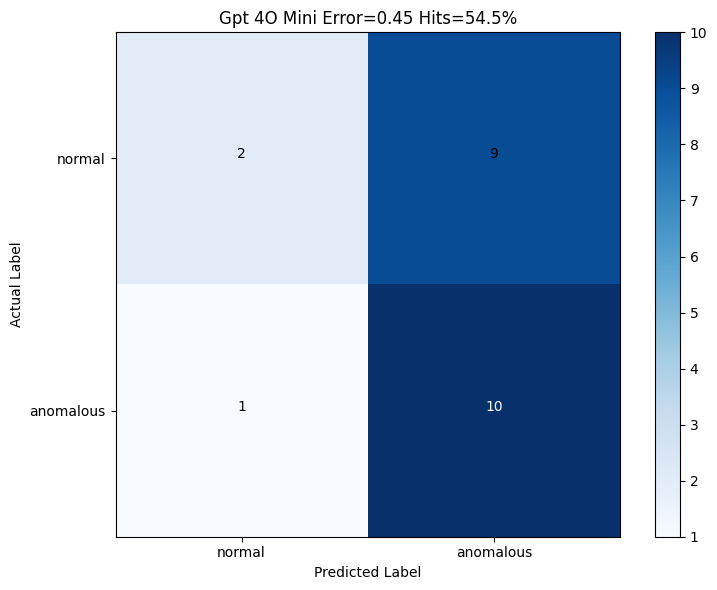

In [18]:
Tester.test(gpt_4o_mini, test)

In [19]:
def gpt_4o_frontier(item):
    response = openai.chat.completions.create(
        model="gpt-4o-2024-08-06", 
        messages=messages_for(item),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_result(reply)

1: Guess: anomalous Truth: anomalous Error: False Item: [{"timestamp": 1709341500, "room": "entr...
2: Guess: normal Truth: normal Error: False Item: [{"timestamp": 1738090800, "room": "livi...
3: Guess: anomalous Truth: normal Error: True Item: [{"timestamp": 1741046400, "room": "livi...
4: Guess: anomalous Truth: anomalous Error: False Item: [{"timestamp": 1741082100, "room": "hall...
5: Guess: anomalous Truth: anomalous Error: False Item: [{"timestamp": 1709344800, "room": "bedr...
6: Guess: normal Truth: normal Error: False Item: [{"timestamp": 1709298000, "room": "kitc...
7: Guess: anomalous Truth: anomalous Error: False Item: [{"timestamp": 1709427600, "datetime": "...
8: Guess: normal Truth: anomalous Error: True Item: [{"timestamp": 1804198800, "datetime": "...
9: Guess: normal Truth: normal Error: False Item: [{"timestamp": 1737856800, "datetime": "...
10: Guess: anomalous Truth: anomalous Error: False Item: [{"timestamp": 1737849600, "datetime": "...
11: Guess: normal Truth: 

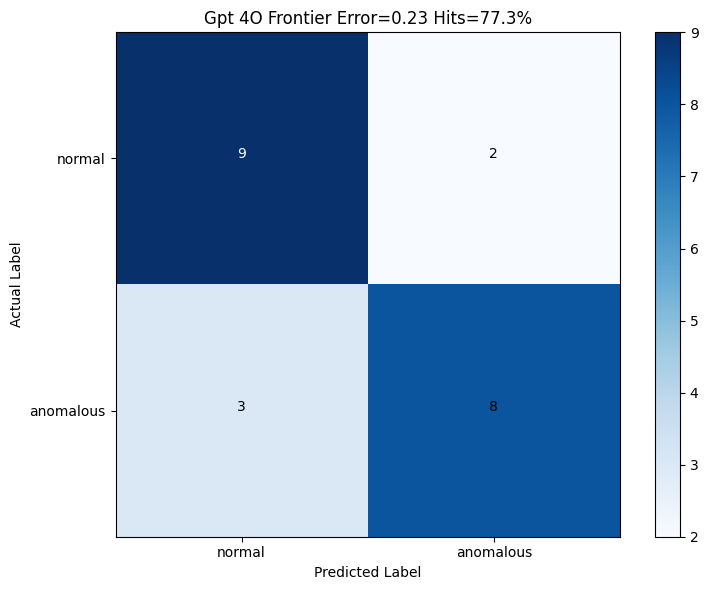

In [20]:
# The function for gpt-4o - the August model
# Note that it cost me about 1-2 cents to run this (pricing may vary by region)
# You can skip this and look at my results instead

Tester.test(gpt_4o_frontier, test)

In [21]:
def claude_3_point_5_sonnet(item):
    messages = messages_for(item)
    system_message = messages[0]['content']
    messages = messages[1:]
    response = claude.messages.create(
        model="claude-3-5-sonnet-20240620",
        max_tokens=5,
        system=system_message,
        messages=messages
    )
    reply = response.content[0].text
    return get_result(reply)

In [22]:
# The function for Claude 3.5 Sonnet
# It also cost me about 1-2 cents to run this (pricing may vary by region)
# You can skip this and look at my results instead

#Tester.test(claude_3_point_5_sonnet, test)

# We will try a Local Model

In [32]:
# There's actually an alternative approach that some people might prefer
# You can use the OpenAI client python library to call Ollama:

from openai import OpenAI
ollama_via_openai = OpenAI(base_url='http://localhost:11434/v1', api_key='ollama')

# This may take a few minutes to run! You should then see a fascinating "thinking" trace inside <think> tags, followed by some decent definitions

response = ollama_via_openai.chat.completions.create(
    model="deepseek-r1:1.5b",
    messages=[{"role": "user", "content": "What is 2+2?"}]
)

print(response.choices[0].message.content)


<think>
I need to determine the value of 2 plus 2.

Step 1: Start with the number 2.

Step 2: Add another 2 to it.

Adding these together, I get 4.

Therefore, 2 plus 2 equals 4.
</think>

Certainly! Let's solve the problem step by step.

**Problem:** What is \(2 + 2\)?

**Solution:**

1. **Identify the numbers involved:**
   
   \[
   2 \quad \text{and} \quad 2
   \]

2. **Add them together:**
   
   \[
   2 + 2 = 4
   \]

Therefore, the final answer is:

\[
\boxed{4}
\]


In [33]:
# Use Ollama API to query the local `deepseek` model
def deepseek(item):
    response = ollama_via_openai.chat.completions.create(
        model="deepseek-r1:1.5b",
        messages=messages_for(item),
        seed=42
    )
    reply = response.choices[0].message.content
    #print(reply)
    return get_result(reply)
    




1: Guess: normal Truth: anomalous Error: True Item: [{"timestamp": 1709344800, "room": "bedr...
2: Guess: normal Truth: normal Error: False Item: [{"timestamp": 1738072800, "room": "livi...
3: Guess: normal Truth: normal Error: False Item: [{"timestamp": 1709413200, "room": "livi...
4: Guess: normal Truth: anomalous Error: True Item: [{"timestamp": 1740553200, "datetime": "...
5: Guess: normal Truth: anomalous Error: True Item: [{"timestamp": 1709247600, "room": "livi...
6: Guess: normal Truth: normal Error: False Item: [{"timestamp": 1709294400, "room": "livi...
7: Guess: normal Truth: anomalous Error: True Item: [{"timestamp": 1741086000, "room": "bath...
8: Guess: normal Truth: anomalous Error: True Item: [{"timestamp": 1740560400, "datetime": "...
9: Guess: anomalous Truth: normal Error: True Item: [{"timestamp": 1741269600, "datetime": "...
10: Guess: anomalous Truth: anomalous Error: False Item: [{"timestamp": 1741262400, "datetime": "...
11: Guess: normal Truth: normal Error: Fa

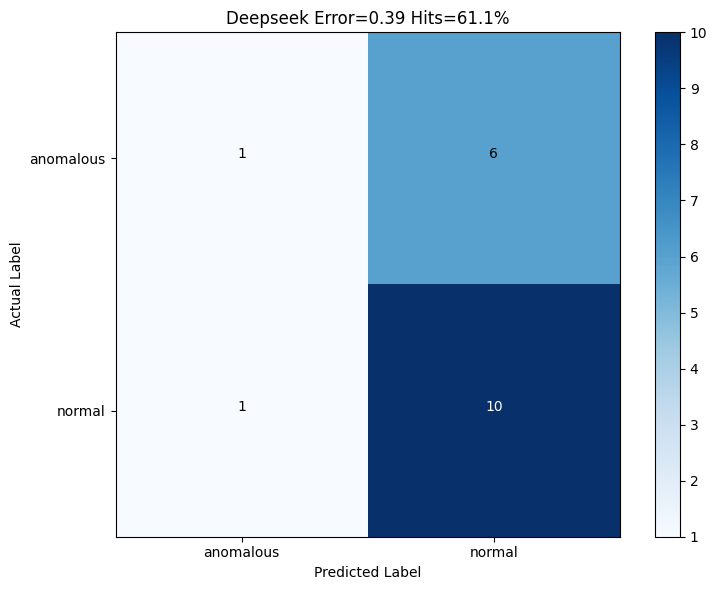

In [34]:
# The function for local install of deepseek
# This takes a long time and could hammer your machine
# You can skip this and look at my results instead

Tester.test(deepseek, test)

# We will try the Emerging models using Openrouter (API provider)



## Lets try Deepskeep with Openrouter!

And now - we put the Deepseek Models to the test.

In [35]:
client = OpenAI(
  base_url="https://openrouter.ai/api/v1",
  api_key=os.environ['OPENROUTER_API_KEY'],
)


In [36]:
completion = client.chat.completions.create(
  model="deepseek/deepseek-r1:free",
  messages=[
    {
      "role": "user",
      "content": "What is 2+2?"
    }
  ]
)
#print(completion)

In [37]:
#If you get 'Too may requests' you may need to topup credit
print(completion.choices[0].message.content)

The result of 2 + 2 is **4**. This is a basic arithmetic operation where two quantities of 2 are combined, yielding a total of 4 when added together. In standard base-10 mathematics, this calculation holds universally true. 

**Answer:**  
2 + 2 equals 4.


In [38]:

import requests
import json

openrouter_api_key = os.environ['OPENROUTER_API_KEY']


response = requests.post(
  url="https://openrouter.ai/api/v1/chat/completions",
  headers={
    "Authorization": "Bearer " + os.environ['OPENROUTER_API_KEY'],
  },
  data=json.dumps({
    "model": "Qwen/Qwen2.5-72B-Instruct", # Optional
    "messages": [
      {
        "role": "user",
        "content": "What is 2+2?"
      }
    ]
  })
)

print(response.json())

{'id': 'gen-1740928601-L8ZhIZNh8YnqBfM4eBB7', 'provider': 'Together', 'model': 'qwen/qwen-2.5-72b-instruct', 'object': 'chat.completion', 'created': 1740928601, 'choices': [{'logprobs': None, 'finish_reason': 'stop', 'native_finish_reason': 'stop', 'index': 0, 'message': {'role': 'assistant', 'content': '2 + 2 equals 4.', 'refusal': None}}], 'usage': {'prompt_tokens': 15, 'completion_tokens': 9, 'total_tokens': 24}}


# Lets try Hyperbolic (API provider)

In [39]:
import requests

url = "https://api.hyperbolic.xyz/v1/chat/completions"
headers = {
    "Content-Type": "application/json",
    "Authorization": "Bearer " + os.environ['HYPERBOLIC_API_KEY']
}
data = {
    "messages": [
        {
            "role": "user",
            "content": "What is 2+2?"
        }
    ],
    "model": "Qwen/Qwen2.5-72B-Instruct",
    "max_tokens": 512,
    "temperature": 0.7,
    "top_p": 0.9
}
  
response = requests.post(url, headers=headers, json=data)
print(response.json())

{'id': 'chatcmpl-jTURDTLnK2X3TfjreiXw4Y', 'object': 'chat.completion', 'created': 1740928603, 'model': 'Qwen/Qwen2.5-72B-Instruct', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': '\n2+2 is 4.', 'tool_calls': []}, 'finish_reason': 'stop', 'logprobs': None}], 'usage': {'prompt_tokens': 14, 'total_tokens': 23, 'completion_tokens': 9}}


In [40]:
import requests

url = "https://api.hyperbolic.xyz/v1/chat/completions"
headers = {
    "Content-Type": "application/json",
    "Authorization": "Bearer " + os.environ['HYPERBOLIC_API_KEY']
}
data = {
    "messages": [
        {
            "role": "user",
            "content": "What is 2 + 2?"
        }
    ],
    "model": "deepseek-ai/DeepSeek-R1",
    "max_tokens": 508,
    "temperature": 0.1,
    "top_p": 0.9
}
  
response = requests.post(url, headers=headers, json=data)
print(response.json())

{'id': 'chatcmpl-EFygdNkDXEjsW3K52HTS9d', 'object': 'chat.completion', 'created': 1740928633, 'model': 'deepseek-ai/DeepSeek-R1', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': "<think>Okay, so I need to figure out what 2 plus 2 is. Let me start by recalling basic addition. When you add two numbers, you're combining their values. So if I have 2 apples and someone gives me 2 more apples, how many apples do I have in total?\n\nLet me count on my fingers. Hold up two fingers on one hand: that's 2. Then hold up two more fingers on the other hand: that's another 2. Now, if I put them together, how many fingers am I holding up? Let's count: one, two, three, four. So that's 4 fingers. Therefore, 2 plus 2 should equal 4.\n\nWait, but maybe I should double-check to make sure I didn't make a mistake. Sometimes when you're counting, you might skip a number or count one twice. Let me try another method. If I start at the number 2 on a number line and then take two steps forwa

In [41]:
# Lets try hyperbolic using the Open AI library
hyperbolic_client = OpenAI(
  base_url="https://api.hyperbolic.xyz/v1",
  api_key=os.environ['HYPERBOLIC_API_KEY'],
)

In [42]:
completion = hyperbolic_client.chat.completions.create(
  model="deepseek-ai/DeepSeek-R1",
  messages=[
    {
      "role": "user",
      "content": "What is 2+2?"
    }
  ]
)
print(completion.choices[0].message.content)

<think>Okay, so I need to figure out what 2 plus 2 is. Let me start by recalling basic addition. I know that addition is combining two numbers to get a total. So if I have 2 apples and someone gives me 2 more apples, how many do I have in total? Let me count on my fingers. Hold up two fingers on one hand, that's 2. Then add two more fingers on the other hand, that's another 2. Now if I count all the fingers up, it's 1, 2, 3, 4. So that makes 4. Wait, but maybe I should double-check. Sometimes when you're adding, especially with small numbers, it's easy to miscount. Let me try another way. If I start at 2 and then add 2 more, like taking steps: 2, then 3, 4. So two steps forward from 2 gets me to 4. Hmm, that still gives me 4. Maybe I can use objects. Let's say I have 2 pencils. I take 2 more pencils. Now I line them up: 1, 2, 3, 4. Yep, that's 4 pencils. Is there a mathematical way to verify this? Well, in the decimal system, 2 is represented as '2', and adding another 2 would mean 2 u

In [101]:
import json

# Use Hyperbolic API to query the deepseek model
def deepseek_via_hyperbolic(item):
    response = hyperbolic_client.chat.completions.create(
        model="deepseek-ai/DeepSeek-R1",
        messages=messages_for(item),
        seed=42
    )
    print(json.dumps(response.__dict__, indent=4, default=str))
    reply = response.choices[0].message.content
    #print(reply)
    return get_result(reply)

In [102]:
test[0].prompt

'How would you classify this sensor data - normal or anomalous?\n\n[{"timestamp": 1709344800, "room": "bedroom", "nodeId": 2, "endpointId": 1, "attribute": {"OccupancySensing": {"Occupancy": 1}}, "datetime": "Sat Mar 02 2024 02:00:00"}, {"timestamp": 1709345700, "room": "bedroom", "nodeId": 2, "endpointId": 2, "attribute": {"TemperatureMeasurement": {"MeasuredValue": 1900}}, "datetime": "Sat Mar 02 2024 02:15:00"}, {"timestamp": 1709349300, "room": "bedroom", "nodeId": 2, "endpointId": 2, "attribute": {"TemperatureMeasurement": {"MeasuredValue": 1900}}, "datetime": "Sat Mar 02 2024 03:15:00"}, {"timestamp": 1709352900, "room": "bedroom", "nodeId": 2, "endpointId": 2, "attribute": {"TemperatureMeasurement": {"MeasuredValue": 1900}}, "datetime": "Sat Mar 02 2024 04:15:00"}]\n\n\nResult is anomalous'

In [103]:
print(deepseek_via_hyperbolic(test[0]))

{
    "id": "chatcmpl-csa598jkCvw2dFKEHGsrHA",
    "choices": [
        "Choice(finish_reason=None, index=0, logprobs=None, message=ChatCompletionMessage(content='', refusal=None, role='assistant', audio=None, function_call=None, tool_calls=[]))"
    ],
    "created": 1740929508,
    "model": "deepseek-ai/DeepSeek-R1",
    "object": "chat.completion",
    "service_tier": null,
    "system_fingerprint": null,
    "usage": "CompletionUsage(completion_tokens=0, prompt_tokens=361, total_tokens=361, completion_tokens_details=None, prompt_tokens_details=None)",
    "_request_id": null
}
None


1: Guess: normal Truth: anomalous Error: True Item: [{"timestamp": 1738152000, "room": "pill...
2: Guess: normal Truth: anomalous Error: True Item: [{"timestamp": 1738695600, "room": "bath...
3: Guess: normal Truth: anomalous Error: True Item: [{"timestamp": 1738411200, "room": "pill...
4: Guess: normal Truth: anomalous Error: True Item: [{"timestamp": 1738843200, "room": "pill...
5: Guess: normal Truth: normal Error: False Item: [{"timestamp": 1738238400, "room": "pill...
6: Guess: normal Truth: normal Error: False Item: [{"timestamp": 1739078400, "room": "bath...
7: Guess: normal Truth: anomalous Error: True Item: [{"timestamp": 1738843200, "room": "pill...
8: Guess: normal Truth: anomalous Error: True Item: [{"timestamp": 1738627200, "room": "livi...
9: Guess: normal Truth: normal Error: False Item: [{"timestamp": 1738756800, "room": "pill...
10: Guess: normal Truth: normal Error: False Item: [{"timestamp": 1739203200, "room": "bath...
11: Guess: normal Truth: anomalous Error: True 

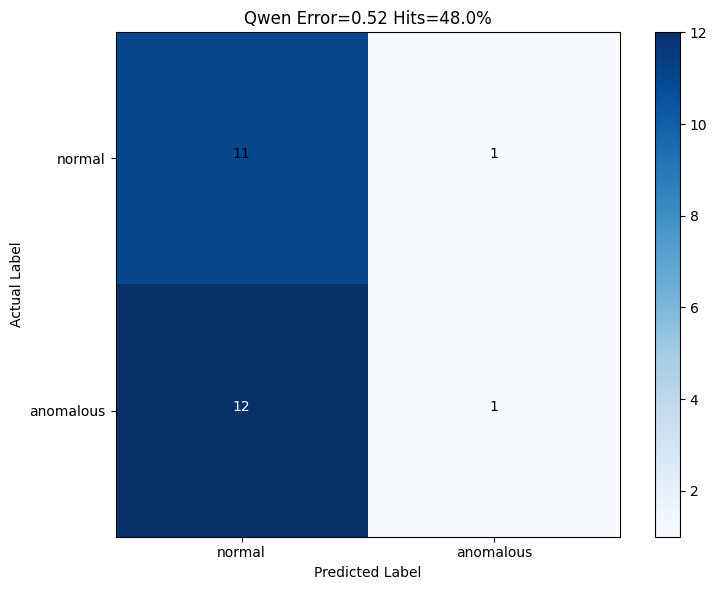

In [49]:
# The function for testing deepseek via hyperbolic

Tester.test(deepseek_via_hyperbolic, test)

## We will know try to improve the Frontier Models chances

### First the problem with timestamps and time reasoning

In [80]:
timestamp = 1740833306 # this is Sat Mar 01 2025 20:05:27 GMT+0000

def make_prompt():
    return [
        {"role": "system", "content": "You can control smart home sensor data in a smart home. The timezone here is GMT."},
        {"role": "user", "content": f"The unix timestamp is {timestamp}. Should I turn on the lights?"},
        {"role": "assistant", "content": "The answer is: "}
    ]

print(make_prompt())


[{'role': 'system', 'content': 'You can control smart home sensor data in a smart home. The timezone here is GMT.'}, {'role': 'user', 'content': 'The unix timestamp is 1740833306. Should I turn on the lights?'}, {'role': 'assistant', 'content': 'The answer is: '}]


In [81]:
response = openai.chat.completions.create(
    model="gpt-4o-2024-08-06", 
    messages=make_prompt(),
    seed=42,
)
reply = response.choices[0].message.content

In [82]:
reply

"To determine whether you should turn on the lights, first convert the given Unix timestamp to a human-readable date and time.\n\nThe Unix timestamp 1740833306 corresponds to:\n- Date: Tuesday, June 30, 2025\n- Time: 16:28:26 GMT\n\nNow, consider the current policies or conditions set for turning on the lights. Typically, lights are turned on when it's dark outside, which often means during nighttime or in dimly lit conditions. \n\nAt 16:28 GMT in late June, it is likely still daylight in many locations. Therefore, unless you have specific conditions or preferences for turning on the lights at this time, it might not be necessary. However, if it's been a cloudy day or there are specific needs for light, you can choose to turn them on based on personal or automated settings."

In [83]:
#Lets look at the timestamp and use a readable time

readabletime = "Sat Mar 01 2025 20:05:27"
 
def make_prompt_with_time():
    return [
        {"role": "system", "content": "You can control smart home sensor data in a smart home. The timezone here is GMT."},
        {"role": "user", "content": f"The time is {readabletime}. Should I turn on the lights?"},
        {"role": "assistant", "content": "The answer is: "}
    ]

print(make_prompt_with_time())

[{'role': 'system', 'content': 'You can control smart home sensor data in a smart home. The timezone here is GMT.'}, {'role': 'user', 'content': 'The time is Sat Mar 01 2025 20:05:27. Should I turn on the lights?'}, {'role': 'assistant', 'content': 'The answer is: '}]


In [84]:
response = openai.chat.completions.create(
    model="gpt-4o-2024-08-06", 
    messages=make_prompt_with_time(),
    seed=42,
)
reply = response.choices[0].message.content

In [85]:
reply

"It depends on your preferences and the natural lighting in your area at that time. At 8:05 PM in early March, it's likely to be dark outside, so you may want to turn on the lights for visibility and comfort. If you have any automated settings or preferences for when the lights come on, you might also consider those."

## Assess the Situation not the logs

In [86]:
from datetime import datetime
TIMEZONE = datetime.now().astimezone().tzinfo

SYSTEM_PROMPT = f"The timezone here is {str(TIMEZONE)}. "
SYSTEM_PROMPT += """Your task is to analyze log entries from home sensors from a home occupied by an elderly person by providing a human-readable scenario. Generate a neutral narrative that describes what occurred during that period. Important: The narrative must describe the events in relation to the person without any judgment about whether they are normal or anomalous. 

Ensure the output includes a description which is A concise, neutral summary (4-5 sentences) of the events that took place during the hour. This description should detail the observed movement patterns and sensor events without implying any evaluation.

Important rules:

Do not include any evaluative or judgmental language in the situation description. The narrative should allow a human or another LLM to independently assess whether the events are typical for an elderly person in the house.
When describing movements and events, you should mention human readable times of these movements and events but ensure that times used are consistent with the provided start and end timestamps.
The events that are described should be related to the person not the smart device

The output format must be a string

"""

USER_PROMPT_PREFIX = """Analyze the following block of log entries and create a neutral, human-readable scenario description of the events observed. 
Your description should summarize the recorded movement patterns in 4-5 clear sentences without including any evaluative language regarding whether the movement is 
typical or atypical. 
Here are the log entries:

"""


In [87]:
SYSTEM_PROMPT

'The timezone here is GMT. Your task is to analyze log entries from home sensors from a home occupied by an elderly person by providing a human-readable scenario. Generate a neutral narrative that describes what occurred during that period. Important: The narrative must describe the events in relation to the person without any judgment about whether they are normal or anomalous. \n\nEnsure the output includes a description which is A concise, neutral summary (4-5 sentences) of the events that took place during the hour. This description should detail the observed movement patterns and sensor events without implying any evaluation.\n\nImportant rules:\n\nDo not include any evaluative or judgmental language in the situation description. The narrative should allow a human or another LLM to independently assess whether the events are typical for an elderly person in the house.\nWhen describing movements and events, you should mention human readable times of these movements and events but e

In [88]:
def make_user_prompt(item) -> str:
    """
    Create a user prompt for OpenAI based on the scraped deals provided
    """
    user_prompt = USER_PROMPT_PREFIX
    user_prompt += item.details
    return user_prompt

In [89]:
make_user_prompt(test[0])

'Analyze the following block of log entries and create a neutral, human-readable scenario description of the events observed. \nYour description should summarize the recorded movement patterns in 4-5 clear sentences without including any evaluative language regarding whether the movement is \ntypical or atypical. \nHere are the log entries:\n\n[{"timestamp": 1709344800, "room": "bedroom", "nodeId": 2, "endpointId": 1, "attribute": {"OccupancySensing": {"Occupancy": 1}}, "datetime": "Sat Mar 02 2024 02:00:00"}, {"timestamp": 1709345700, "room": "bedroom", "nodeId": 2, "endpointId": 2, "attribute": {"TemperatureMeasurement": {"MeasuredValue": 1900}}, "datetime": "Sat Mar 02 2024 02:15:00"}, {"timestamp": 1709349300, "room": "bedroom", "nodeId": 2, "endpointId": 2, "attribute": {"TemperatureMeasurement": {"MeasuredValue": 1900}}, "datetime": "Sat Mar 02 2024 03:15:00"}, {"timestamp": 1709352900, "room": "bedroom", "nodeId": 2, "endpointId": 2, "attribute": {"TemperatureMeasurement": {"Mea

In [92]:
def messages_for_description(item):
    system_message = "You look for normal and anomalous situations in smart home sensor data in an elderly persons home. Reply only with the word normal or anomalous, no explanation. You should consider the timing of the events and whether this is typical for an elderly person. You must also consider the time between the events and the sequencing of the events to check if they are normal for an elderly person"
    user_prompt = make_user_prompt(item) 
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Result is "}
    ]

In [93]:
messages_for_description(test[0])

[{'role': 'system',
  'content': 'You look for normal and anomalous situations in smart home sensor data in an elderly persons home. Reply only with the word normal or anomalous, no explanation. You should consider the timing of the events and whether this is typical for an elderly person. You must also consider the time between the events and the sequencing of the events to check if they are normal for an elderly person'},
 {'role': 'user',
  'content': 'Analyze the following block of log entries and create a neutral, human-readable scenario description of the events observed. \nYour description should summarize the recorded movement patterns in 4-5 clear sentences without including any evaluative language regarding whether the movement is \ntypical or atypical. \nHere are the log entries:\n\n[{"timestamp": 1709344800, "room": "bedroom", "nodeId": 2, "endpointId": 1, "attribute": {"OccupancySensing": {"Occupancy": 1}}, "datetime": "Sat Mar 02 2024 02:00:00"}, {"timestamp": 1709345700,

In [94]:
def gpt_4o_frontier_get_situation(item):
 
    response = openai.chat.completions.create(
        model="gpt-4o-2024-08-06", 
        messages=messages_for_description(item),
        seed=42,
        max_tokens=500
    )
    reply = response.choices[0].message.content
    return reply

In [95]:
situation = gpt_4o_frontier_get_situation(test[0])

In [96]:
def messages_with_description_and_time(item):    
    system_message = "You look for normal and anomalous situations in smart home sensor data in an elderly persons home. Reply only with the word normal or anomalous, no explanation. You should consider the timing of the events and whether this is typical for an elderly person. You must also consider the time between the events and the sequencing of the events to check if they are normal for an elderly person"
    user_prompt = item.test_prompt().replace("\n\nResult is ","")
    user_prompt += "A human readable description of this situation is as follows:\n\n" + situation
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Result is "}
    ]

In [97]:
messages_with_description_and_time(test[0])

[{'role': 'system',
  'content': 'You look for normal and anomalous situations in smart home sensor data in an elderly persons home. Reply only with the word normal or anomalous, no explanation. You should consider the timing of the events and whether this is typical for an elderly person. You must also consider the time between the events and the sequencing of the events to check if they are normal for an elderly person'},
 {'role': 'user',
  'content': 'How would you classify this sensor data - normal or anomalous?\n\n[{"timestamp": 1709344800, "room": "bedroom", "nodeId": 2, "endpointId": 1, "attribute": {"OccupancySensing": {"Occupancy": 1}}, "datetime": "Sat Mar 02 2024 02:00:00"}, {"timestamp": 1709345700, "room": "bedroom", "nodeId": 2, "endpointId": 2, "attribute": {"TemperatureMeasurement": {"MeasuredValue": 1900}}, "datetime": "Sat Mar 02 2024 02:15:00"}, {"timestamp": 1709349300, "room": "bedroom", "nodeId": 2, "endpointId": 2, "attribute": {"TemperatureMeasurement": {"Measu

In [98]:
def gpt_4o_frontier_with_description_and_time(item):
    response = openai.chat.completions.create(
        model="gpt-4o-2024-08-06", 
        messages=messages_with_description_and_time(item),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_result(reply)

In [99]:
gpt_4o_frontier_with_description_and_time(test[0])

'normal'

1: Guess: normal Truth: anomalous Error: True Item: [{"timestamp": 1709344800, "room": "bedr...
2: Guess: normal Truth: normal Error: False Item: [{"timestamp": 1738072800, "room": "livi...
3: Guess: normal Truth: normal Error: False Item: [{"timestamp": 1709413200, "room": "livi...
4: Guess: anomalous Truth: anomalous Error: False Item: [{"timestamp": 1740553200, "datetime": "...
5: Guess: anomalous Truth: anomalous Error: False Item: [{"timestamp": 1709247600, "room": "livi...
6: Guess: normal Truth: normal Error: False Item: [{"timestamp": 1709294400, "room": "livi...
7: Guess: normal Truth: anomalous Error: True Item: [{"timestamp": 1741086000, "room": "bath...
8: Guess: normal Truth: anomalous Error: True Item: [{"timestamp": 1740560400, "datetime": "...
9: Guess: normal Truth: normal Error: False Item: [{"timestamp": 1741269600, "datetime": "...
10: Guess: normal Truth: anomalous Error: True Item: [{"timestamp": 1741262400, "datetime": "...
11: Guess: normal Truth: normal Error: 

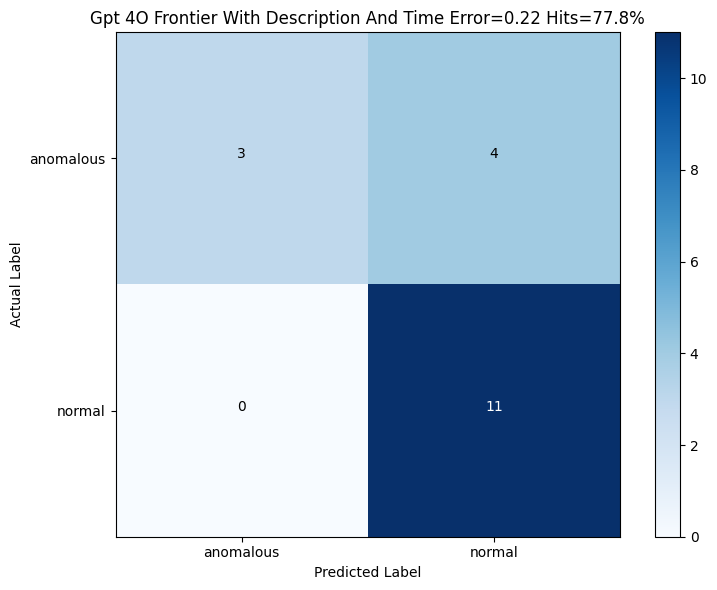

In [100]:
Tester.test(gpt_4o_frontier_with_description_and_time, test)